In [1]:
import os
import time
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import bottleneck as bn
from scipy import sparse
import matplotlib.pyplot as plt

## Model

In [2]:
class MultiDAE(nn.Module):

    def __init__(self, p_dims, q_dims=None, dropout=0.5):
        super(MultiDAE, self).__init__()
        self.p_dims = p_dims
        if q_dims:
            assert q_dims[0] == p_dims[-1], "In and Out dimensions must equal to each other"
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q- network mismatches."
            self.q_dims = q_dims
        else:
            self.q_dims = p_dims[::-1]

        self.dims = self.q_dims + self.p_dims[1:]
        self.layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.dims[:-1], self.dims[1:])])
        self.drop = nn.Dropout(dropout)
        
        self.init_weights()
    
    def forward(self, input):
        h = F.normalize(input)
        h = self.drop(h)

        for i, layer in enumerate(self.layers):
            h = layer(h)
            if i != len(self.weights) - 1:
                h = F.tanh(h)
        return h

    def init_weights(self):
        for layer in self.layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)


class MultiVAE(nn.Module):

    def __init__(self, p_dims, q_dims=None, dropout=0.5):
        super(MultiVAE, self).__init__()
        self.p_dims = p_dims
        if q_dims:
            assert q_dims[0] == p_dims[-1], "In and Out dimensions must equal to each other"
            assert q_dims[-1] == p_dims[0], "Latent dimension for p- and q- network mismatches."
            self.q_dims = q_dims
        else:
            self.q_dims = p_dims[::-1]

        # Last dimension of q- network is for mean and variance
        temp_q_dims = self.q_dims[:-1] + [self.q_dims[-1] * 2]
        self.q_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(temp_q_dims[:-1], temp_q_dims[1:])])
        self.p_layers = nn.ModuleList([nn.Linear(d_in, d_out) for
            d_in, d_out in zip(self.p_dims[:-1], self.p_dims[1:])])
        
        self.drop = nn.Dropout(dropout)
        self.init_weights()
    
    def forward(self, input):
        mu, logvar = self.encode(input)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
    def encode(self, input):
        h = F.normalize(input)
        h = self.drop(h)
        
        for i, layer in enumerate(self.q_layers):
            h = layer(h)
            if i != len(self.q_layers) - 1:
                h = F.tanh(h)
            else:
                mu = h[:, :self.q_dims[-1]]
                logvar = h[:, self.q_dims[-1]:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def decode(self, z):
        h = z
        for i, layer in enumerate(self.p_layers):
            h = layer(h)
            if i != len(self.p_layers) - 1:
                h = F.tanh(h)
        return h

    def init_weights(self):
        for layer in self.q_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)
        
        for layer in self.p_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0/(fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for Biases
            layer.bias.data.normal_(0.0, 0.001)

def loss_function(recon_x, x, mu, logvar, anneal=1.0):
    # BCE = F.binary_cross_entropy(recon_x, x)
    BCE = -torch.mean(torch.sum(F.log_softmax(recon_x, 1) * x, -1))
    KLD = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))

    return BCE + anneal * KLD

## Metric

Evaluate function: Normalized discounted cumulative gain (NDCG@k)  Recall@k and Precision@k

In [3]:
def ndcg_binary_at_k_batch(x_pred, heldout_batch, k=100):
    """
    normalized discounted cumulative gain@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    """
    batch_users = x_pred.shape[0]
    idx_topk_part = bn.argpartition(-x_pred, k, axis=1)
    topk_part = x_pred[np.arange(batch_users)[:, np.newaxis],
                       idx_topk_part[:, :k]]
    idx_part = np.argsort(-topk_part, axis=1)
    # X_pred[np.arange(batch_users)[:, np.newaxis], idx_topk] is the sorted
    # topk predicted score
    idx_topk = idx_topk_part[np.arange(batch_users)[:, np.newaxis], idx_part]
    # build the discount template
    tp = 1. / np.log2(np.arange(2, k + 2))

    dcg = (heldout_batch[np.arange(batch_users)[:, np.newaxis],
                         idx_topk].toarray() * tp).sum(axis=1)
    idcg = np.array([(tp[:min(n, k)]).sum()
                     for n in heldout_batch.getnnz(axis=1)])
    ndcg = dcg / idcg
    ndcg[np.isnan(ndcg)] = 0
    return ndcg


def recall_at_k_batch(x_pred, heldout_batch, k=100):
    batch_users = x_pred.shape[0]

    idx = bn.argpartition(-x_pred, k, axis=1)
    x_pred_binary = np.zeros_like(x_pred, dtype=bool)
    x_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    x_true_binary = (heldout_batch > 0).toarray()
    tmp = (np.logical_and(x_true_binary, x_pred_binary).sum(axis=1)).astype(
        np.float32)
    recall = tmp / np.minimum(k, x_true_binary.sum(axis=1))
    recall[np.isnan(recall)] = 0
    return recall


def precision_at_k_batch(X_pred, heldout_batch, k=100):
    '''
    Precision@k for binary relevance
    ASSUMPTIONS: all the 0's in heldout_data indicate 0 relevance
    - X_pred: Predictive score matrix, where each row represents a user and each column represents an item
    - heldout_batch: Real user-item interaction data, again, each row represents a user and each column represents an item
    - k: Number of top recommendations considered
    '''
    batch_users = X_pred.shape[0]
    
    # Find the top k highest predicted scores for each user using argpartition
    idx = bn.argpartition(-X_pred, k, axis=1)
    # Create a matrix that is all False and then set the top k highest scores to True
    X_pred_binary = np.zeros_like(X_pred, dtype=bool)
    X_pred_binary[np.arange(batch_users)[:, np.newaxis], idx[:, :k]] = True

    # Converts heldout_batch to a binary format indicating whether the user is interested in the item or not
    X_true_binary = (heldout_batch > 0).toarray()
    # Calculate the number of correct predictions for each user
    true_positives = np.logical_and(X_true_binary, X_pred_binary).sum(axis=1)
    # Calculate and return precision@k
    precision_at_k = true_positives.astype(np.float32) / k
    return precision_at_k

## Training/validation data, hyperparameters

Load the pre-processed training and validation data

In [4]:
processed_dataset = r'C:\Users\FOMO\Desktop\Proj\Dataset\GoodReads\processed_data'

In [5]:
unique_sid = list()
with open(os.path.join(processed_dataset, 'unique_sid.txt'), 'r') as f:
    for line in f:
        unique_sid.append(line.strip())

n_items = len(unique_sid)

In [6]:
def load_train_data(csv_file):
    tp = pd.read_csv(csv_file)
    n_users = tp['uid'].max() + 1

    rows, cols = tp['uid'], tp['sid']
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_items))
    return data

In [7]:
train_data = load_train_data(os.path.join(processed_dataset, 'train.csv'))

In [8]:
def load_tr_te_data(csv_file_tr, csv_file_te):
    tp_tr = pd.read_csv(csv_file_tr)
    tp_te = pd.read_csv(csv_file_te)

    start_idx = min(tp_tr['uid'].min(), tp_te['uid'].min())
    end_idx = max(tp_tr['uid'].max(), tp_te['uid'].max())

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']
    rows_te, cols_te = tp_te['uid'] - start_idx, tp_te['sid']

    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    data_te = sparse.csr_matrix((np.ones_like(rows_te),
                             (rows_te, cols_te)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))
    return data_tr, data_te

In [9]:
vad_data_tr, vad_data_te = load_tr_te_data(os.path.join(processed_dataset, 'validation_tr.csv'),
                                           os.path.join(processed_dataset, 'validation_te.csv'))

In [10]:
test_data_tr, test_data_te = load_tr_te_data(
    os.path.join(processed_dataset, 'test_tr.csv'),
    os.path.join(processed_dataset, 'test_te.csv'))

Set up training hyperparameters

In [11]:
lr = 1e-4
wd = 0.00 # weight decay coefficient
batch_size = 500
epochs = 50
total_anneal_steps = 200000 # the total number of gradient updates for annealing
anneal_cap = 0.2 
seed = 1111 # random seed
log_interval = 100
save = r'C:\Users\FOMO\Desktop\Proj\BookRS\Save_MultVAE\GoodReads\model.pt' # path to save the final model

In [12]:
N = train_data.shape[0]
idxlist = list(range(N))

## Build the model

In [13]:
torch.manual_seed(seed) # Set the random seed manually for reproductibility.
device = torch.device("cuda:0")

In [14]:
p_dims = [200, 600, n_items]
model = MultiVAE(p_dims).to(device)

In [15]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=wd)
criterion = loss_function

### Train a MultVAE

In [16]:
def sparse2torch_sparse(data):
    samples = data.shape[0]
    features = data.shape[1]
    coo_data = data.tocoo()
    indices = torch.LongTensor([coo_data.row, coo_data.col])
    row_norms_inv = 1 / np.sqrt(data.sum(1))
    row2val = {i : row_norms_inv[i].item() for i in range(samples)}
    values = np.array([row2val[r] for r in coo_data.row])
    t = torch.sparse.FloatTensor(indices, torch.from_numpy(values).float(), [samples, features])
    return t

def naive_sparse2tensor(data):
    return torch.FloatTensor(data.toarray())

def evaluate(data_tr, data_te):
    # Turn on evaluation mode
    model.eval()
    total_loss = 0.0
    global update_count
    e_idxlist = list(range(data_tr.shape[0]))
    e_N = data_tr.shape[0]
    
    metrics = {
        'n5': [], 'n10': [], 'n20': [], 'n50': [], 'n100': [],
        'r5': [], 'r10': [], 'r20': [], 'r50': [], 'r100': [],
        'p5': [], 'p10': [], 'p20': [], 'p50': [], 'p100': [],
    }
    
    with torch.no_grad():
        for start_idx in range(0, e_N, batch_size):
            end_idx = min(start_idx + batch_size, e_N)
            data = data_tr[e_idxlist[start_idx:end_idx]]
            heldout_data = data_te[e_idxlist[start_idx:end_idx]]

            data_tensor = naive_sparse2tensor(data).to(device)

            if total_anneal_steps > 0:
                anneal = min(anneal_cap, 
                               1. * update_count / total_anneal_steps)
            else:
                anneal = anneal_cap

            recon_batch, mu, logvar = model(data_tensor)

            loss = criterion(recon_batch, data_tensor, mu, logvar, anneal)
            total_loss += loss.item()

            # Exclude examples from training set
            recon_batch = recon_batch.cpu().numpy()
            recon_batch[data.nonzero()] = -np.inf

            for k in [5, 10, 20, 50, 100]:
                ndcg = ndcg_binary_at_k_batch(recon_batch, heldout_data, k)
                recall = recall_at_k_batch(recon_batch, heldout_data, k)
                precision = precision_at_k_batch(recon_batch, heldout_data, k)
                
                metrics['n{}'.format(k)].append(ndcg)
                metrics['r{}'.format(k)].append(recall)
                metrics['p{}'.format(k)].append(precision)
    
    # Aggregate results
    total_loss /= len(range(0, e_N, batch_size))
    for key in metrics:
        metrics[key] = np.mean(np.concatenate(metrics[key]))

    return total_loss, metrics

In [17]:
best_n100 = -np.inf
update_count = 0
ndcg100_values = []

In [18]:
# At any point you can hit Ctrl + C to break out of training early.
try:
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()

        # Training code integrated here
        model.train()
        train_loss = 0.0
        start_time = time.time()

        np.random.shuffle(idxlist)
        
        for batch_idx, start_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(start_idx + batch_size, N)
            data = train_data[idxlist[start_idx:end_idx]]
            data = naive_sparse2tensor(data).to(device)

            if total_anneal_steps > 0:
                anneal = min(anneal_cap, 
                                1. * update_count / total_anneal_steps)
            else:
                anneal = anneal_cap

            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            
            loss = criterion(recon_batch, data, mu, logvar, anneal)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            update_count += 1

            if batch_idx % log_interval == 0 and batch_idx > 0:
                elapsed = time.time() - start_time
                print('| epoch {:3d} | {:4d}/{:4d} batches | ms/batch {:4.2f} | '
                        'loss {:4.2f}'.format(
                            epoch, batch_idx, len(range(0, N, batch_size)),
                            elapsed * 1000 / log_interval,
                            train_loss / log_interval))
                
                start_time = time.time()
                train_loss = 0.0

        # Evaluation code remains unchanged
        val_loss, metrics = evaluate(vad_data_tr, vad_data_te)
        ndcg100_values.append(metrics['n100'])
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:4.2f}s | valid loss {:4.2f} | '
                'n100 {:5.3f} | r20 {:5.3f} | r50 {:5.3f}'.format(
                    epoch, time.time() - epoch_start_time, val_loss,
                    metrics['n100'], metrics['r20'], metrics['r50']))
        print('-' * 89)

        # Save the model if the n100 is the best we've seen so far.
        if metrics['n100'] > best_n100:
            with open(save, 'wb') as f:
                torch.save(model, f)
            best_n100 = metrics['n100']

except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

# Load the best saved model.
with open(save, 'rb') as f:
    model = torch.load(f)

c:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


| epoch   1 |  100/ 229 batches | ms/batch 218.23 | loss 2403.38
| epoch   1 |  200/ 229 batches | ms/batch 210.52 | loss 2164.31
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 149.20s | valid loss 1693.12 | n100 0.224 | r20 0.185 | r50 0.175
-----------------------------------------------------------------------------------------
| epoch   2 |  100/ 229 batches | ms/batch 204.38 | loss 2083.96
| epoch   2 |  200/ 229 batches | ms/batch 203.48 | loss 2054.52
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 142.97s | valid loss 1635.73 | n100 0.260 | r20 0.218 | r50 0.206
-----------------------------------------------------------------------------------------
| epoch   3 |  100/ 229 batches | ms/batch 204.98 | loss 2042.96
| epoch   3 |  200/ 229 batches | ms/batch 201.02 | loss 1990.52
----------------------------------------------------------------

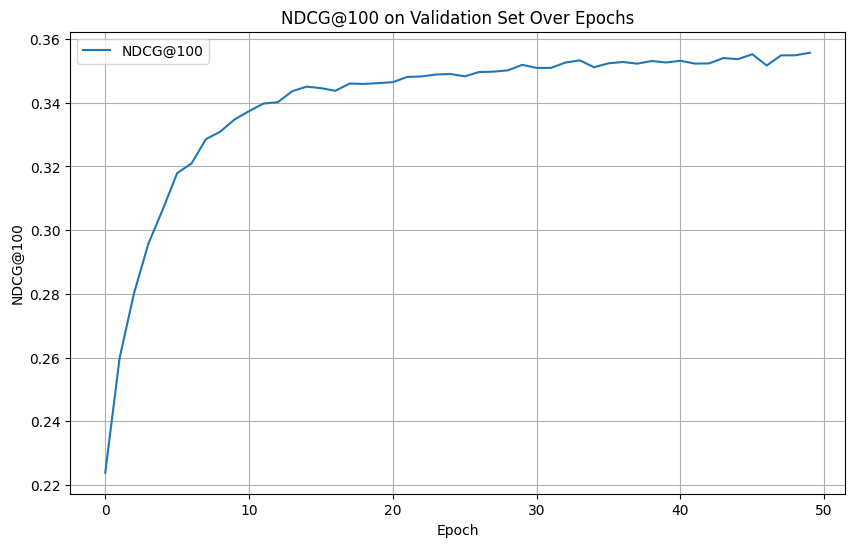

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(ndcg100_values, label='NDCG@100')
plt.xlabel('Epoch')
plt.ylabel('NDCG@100')
plt.title('NDCG@100 on Validation Set Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Evaluate

In [20]:
# Run on test data.
test_loss, metrics = evaluate(test_data_tr, test_data_te)

print('=' * 89)
print('| End of training | test loss {:4.2f}'.format(test_loss))
for k in [5, 10, 20, 50, 100]:
    print('| ndcg@{} {:5.3f} | recall@{} {:5.3f} | precision@{} {:5.3f}'.format(
        k, metrics['n{}'.format(k)], k, metrics['r{}'.format(k)], k, metrics['p{}'.format(k)]))
print('=' * 89)


| End of training | test loss 1509.76
| ndcg@5 0.431 | recall@5 0.420 | precision@5 0.420
| ndcg@10 0.396 | recall@10 0.375 | precision@10 0.375
| ndcg@20 0.345 | recall@20 0.312 | precision@20 0.312
| ndcg@50 0.319 | recall@50 0.295 | precision@50 0.218
| ndcg@100 0.358 | recall@100 0.371 | precision@100 0.153
